Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Watch Aaron's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/Burrito - 10D.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
Burrito           421 non-null object
Date              421 non-null object
Yelp              87 non-null float64
Google            87 non-null float64
Chips             26 non-null object
Cost              414 non-null float64
Hunger            418 non-null float64
Mass (g)          22 non-null float64
Density (g/mL)    22 non-null float64
Length            283 non-null float64
Circum            281 non-null float64
Volume            281 non-null float64
Tortilla          421 non-null float64
Temp              401 non-null float64
Meat              407 non-null float64
Fillings          418 non-null float64
Meat:filling      412 non-null float64
Uniformity        419 non-null float64
Salsa             396 non-null float64
Synergy           419 non-null float64
Wrap              418 non-null float64
Unreliable        33 non-null object
NonSD             7 non-null object
Beef       

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,87.0,3.887356,0.475396,2.50,3.500000,4.000000,4.000000,4.500000
Google,87.0,4.167816,0.373698,2.90,4.000000,4.200000,4.400000,5.000000
Cost,414.0,7.067343,1.506742,2.99,6.250000,6.990000,7.880000,25.000000
Hunger,418.0,3.495335,0.812069,0.50,3.000000,3.500000,4.000000,5.000000
Mass (g),22.0,546.181818,144.445619,350.00,450.000000,540.000000,595.000000,925.000000
Density (g/mL),22.0,0.675277,0.080468,0.56,0.619485,0.658099,0.721726,0.865672
Length,283.0,20.038233,2.083518,15.00,18.500000,20.000000,21.500000,26.000000
Circum,281.0,22.135765,1.779408,17.00,21.000000,22.000000,23.000000,29.000000
Volume,281.0,0.786477,0.152531,0.40,0.680000,0.770000,0.880000,1.540000
Tortilla,421.0,3.519477,0.794438,1.00,3.000000,3.500000,4.000000,5.000000


In [11]:
df.describe(include = object).T

,count,unique,top,freq
Burrito,421,5,California,169
Date,421,169,8/30/2016,29
Chips,26,4,x,21
Unreliable,33,1,x,33
NonSD,7,2,x,5
Beef,179,2,x,137
Pico,158,2,x,127
Guac,154,2,x,114
Cheese,159,2,x,128
Fries,127,2,x,102


In [13]:
df.drop(['Mass (g)', 'Density (g/mL)', 'Queso', 'Date', 'NonSD', 'Lobster', 'Zucchini', 'Carrots', 'Salsa.1'], axis = 1, inplace = True)
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,...,Ham,Chile relleno,Nopales,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Great
0,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [22]:
df['Great'] = df['Great'].astype(int)

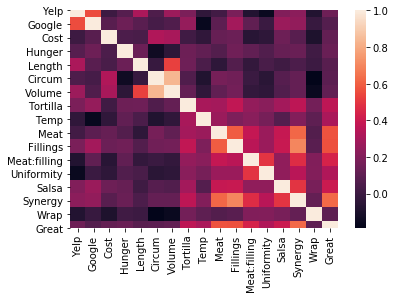

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.heatmap(df[df.describe().T.index].corr())

In [36]:
from sklearn.model_selection import train_test_split

train, valtest = train_test_split(df, test_size = .2)

val, test = train_test_split(valtest, test_size = .5)

train.shape, val.shape, test.shape

((336, 50), (42, 50), (43, 50))

In [40]:
target = 'Great'
y_train = train[target]
baseline = y_train.mean()
y_train.value_counts(normalize = True)

0    0.553571
1    0.446429
Name: Great, dtype: float64

In [42]:
from sklearn.linear_model import LogisticRegression